<a href="https://colab.research.google.com/github/manel98daboussi/Human-Age-Estimation/blob/main/HAE4Categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Author Daboussi Manel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


X,y, label: Training Dataset

D_Test,Y,labell: Test Dataset



In [ ]:
#
from tensorflow.keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from tensorflow.python.keras.layers import LayerNormalization
from tensorflow.keras import layers

In [ ]:
import numpy as np 
import pandas as pd 
import os 
import cv2 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from google.colab.patches import cv2_imshow
categories=["0--14","15--24","25--49","50++"]
path=('/content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Aug2')
classe1=os.path.join(path,categories[0]) 
classe2=os.path.join(path,categories[1]) 
classe3=os.path.join(path,categories[2]) 
classe4=os.path.join(path,categories[3]) 
#classe5=os.path.join(path,categories[4]) 
X = [] 
y_label = [] 
imgsize = 48
def training_data(label,data_dir):
    print ( data_dir) 
    for img in os.listdir(data_dir): 
        path = os.path.join(data_dir,img) 
        img = cv2.imread(path) 
        img = cv2.resize(img,(imgsize,imgsize)) 
        X.append(np.array(img)) 
        y_label.append(str(label)) 
training_data('0--14',classe1) 
training_data('15--24',classe2) 
training_data('25--49',classe3) 
training_data('50+',classe4) 
#training_data('45+',classe5) 

/content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Aug2/0--14
/content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Aug2/15--24
/content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Aug2/25--49
/content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Aug2/50++


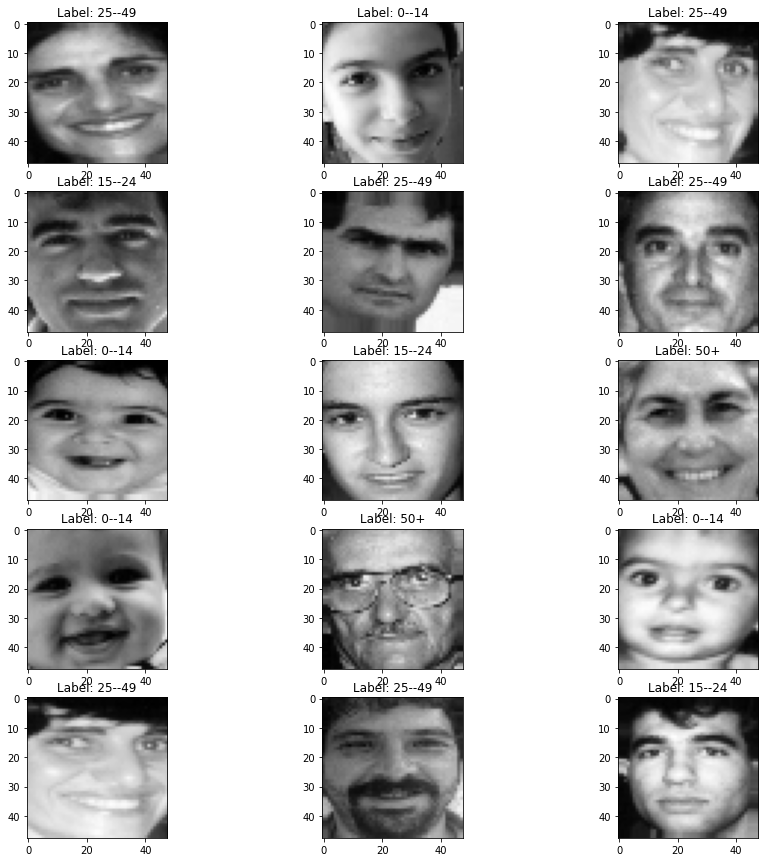

In [ ]:
import matplotlib.pyplot as plt 
import random as rdm 

fig,ax=plt.subplots(5,3) 
fig.set_size_inches(15,15) 
for i in range(5):
    for j in range (3):
        r=rdm.randint(0,len(X)) 
        ax[i,j].imshow(X[r]) 
        ax[i,j].set_title('Label: '+y_label[r]) 
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.utils import to_categorical 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label) 
y = to_categorical(y,4) 
X = np.array(X) 
X=X/255

In [ ]:
X.shape, y.shape

((5203, 48, 48, 3), (5203, 4))

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
X_train.shape, X_test.shape

((3469, 48, 48, 3), (868, 48, 48, 3))

In [ ]:
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')
    return model

In [ ]:
model_custom = create_model()
model_custom.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)             

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
BS=32
EPOCHS = 100

In [ ]:
result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(X):
    X_Train_ =X[train_index]
    Y_Train = y[train_index]
    X_Test_ = X[test_index]
    Y_Test = y[test_index]

    file_path = "/content/drive/MyDrive/enregistrementFG"+str(k_no)+".hdf5"
    checkpoint =  ModelCheckpoint(file_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    callbacks_list = [ early,checkpoint]

    model = create_model()
    #model=cnn
    hist = model.fit(X_Train_, Y_Train, epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    model.load_weights(file_path)
    result.append(model.predict(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    print(scores_acc)
    print(scores_loss)

    k_no+=1

Epoch 1/100
131/131 [==============================] - 13s 97ms/step - loss: 1.1339 - accuracy: 0.4666 - val_loss: 0.6786 - val_accuracy: 0.7416

Epoch 00001: val_accuracy improved from -inf to 0.74159, saving model to /content/drive/MyDrive/enregistrementFG0.hdf5
Epoch 2/100
131/131 [==============================] - 13s 95ms/step - loss: 0.5417 - accuracy: 0.7809 - val_loss: 0.2666 - val_accuracy: 0.9145

Epoch 00002: val_accuracy improved from 0.74159 to 0.91451, saving model to /content/drive/MyDrive/enregistrementFG0.hdf5
Epoch 3/100
131/131 [==============================] - 13s 96ms/step - loss: 0.2616 - accuracy: 0.9061 - val_loss: 0.1443 - val_accuracy: 0.9577

Epoch 00003: val_accuracy improved from 0.91451 to 0.95773, saving model to /content/drive/MyDrive/enregistrementFG0.hdf5
Epoch 4/100
131/131 [==============================] - 13s 96ms/step - loss: 0.1423 - accuracy: 0.9534 - val_loss: 0.0364 - val_accuracy: 0.9933

Epoch 00004: val_accuracy improved from 0.95773 to 0.

<Figure size 432x288 with 0 Axes>

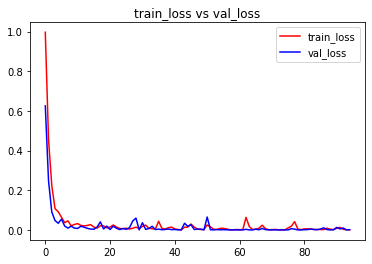

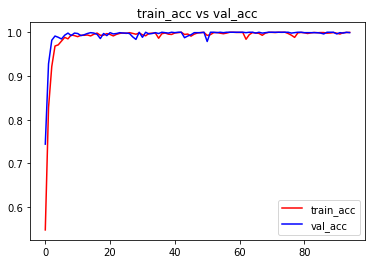

<Figure size 432x288 with 0 Axes>

In [ ]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [ ]:
value_min = min(scores_loss)
value_index = scores_loss.index(value_min)
value_max = max(scores_acc)
#value_index = scores_acc.index(value_max)
print(value_min,value_max)


0.00034122480428777635 1.0


In [ ]:
model.load_weights("/content/drive/MyDrive/enregistrementFG"+str(value_index)+".hdf5")
best_model = model
score = best_model.evaluate(X_Test_, Y_Test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
from sklearn.metrics import classification_report
#predict
prediction=best_model.predict(X_Test_) 
prediction=np.argmax(prediction, axis=1)
y_test1=np.argmax(Y_Test, axis=1)
report = classification_report(y_test1, prediction)
print(report)

Test Loss: 0.00034122480428777635
Test accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       1.00      1.00      1.00       266
           2       1.00      1.00      1.00       267
           3       1.00      1.00      1.00       268

    accuracy                           1.00      1040
   macro avg       1.00      1.00      1.00      1040
weighted avg       1.00      1.00      1.00      1040



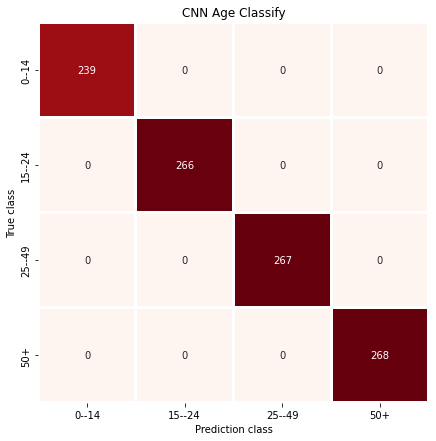

In [ ]:
model.load_weights("/content/drive/MyDrive/enregistrementFG"+str(value_index)+".hdf5")
best_model = model
from sklearn.metrics import confusion_matrix
results = best_model.predict(X_Test_)
results=np.argmax(results,axis=1)
#print(results)
cm = confusion_matrix(np.where(Y_Test == 1)[1], results)
import seaborn as sns
label_mapdisgust = ["0--14","15--24","25--49","50+"]
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )
final_cm = cm_df
plt.figure(figsize = (7,7))
sns.heatmap(final_cm, annot = True,cmap='Reds',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Age Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

In [ ]:
import numpy as np 
import pandas as pd 
import os 
import cv2 
from google.colab.patches import cv2_imshow 
categories= ["0--14","15--24","25--49","50+"]
pathh=('/content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Test/crop')
classe1=os.path.join(pathh,categories[0]) 
classe2=os.path.join(pathh,categories[1]) 
classe3=os.path.join(pathh,categories[2]) 
classe4=os.path.join(pathh,categories[3]) 
#classe5=os.path.join(pathh,categories[4]) 
XX = [] #images sous forme de matrice
labell= [] 
imgsize = 48
def training_data(label,data_dir):
    print ("Dataset：", data_dir) 
    for img in os.listdir(data_dir): 
        path = os.path.join(data_dir,img) 
        img = cv2.imread(path) 
        img = cv2.resize(img,(imgsize,imgsize)) 
        XX.append(np.array(img)) 
        labell.append(str(label)) 
training_data('0--14',classe1)  
training_data('15--24',classe2) 
training_data('25--49',classe3)  
training_data('50+',classe4) 

Dataset： /content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Test/crop/0--14
Dataset： /content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Test/crop/15--24
Dataset： /content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Test/crop/25--49
Dataset： /content/drive/MyDrive/FG-NET Dataset.zip (Unzipped Files)/Test/crop/50+


In [ ]:
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.utils import to_categorical 
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(labell) 
Y = to_categorical(Y,4) 
D_Test = np.array(XX) 
D_Test=D_Test/255

In [ ]:
model.load_weights("/content/drive/MyDrive/enregistrementFG"+str(value_index)+".hdf5")
best_model = model
score = best_model.evaluate(D_Test, Y, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
from sklearn.metrics import classification_report
#predict
prediction=best_model.predict(D_Test) 
prediction=np.argmax(prediction, axis=1)
y_test1=np.argmax(Y, axis=1)
report = classification_report(y_test1, prediction)
print(report)

Test Loss: 0.08802764117717743
Test accuracy: 0.9714285731315613
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        11
           3       1.00      1.00      1.00         2

    accuracy                           0.97        35
   macro avg       0.98      0.98      0.98        35
weighted avg       0.97      0.97      0.97        35



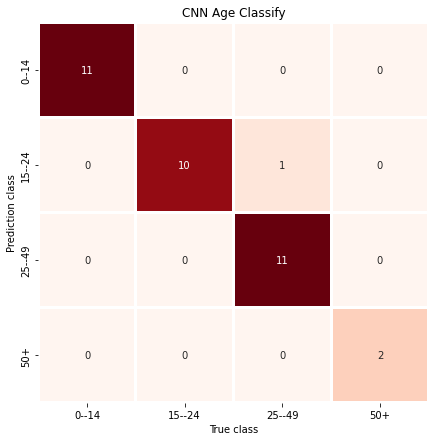

In [ ]:
from sklearn.metrics import confusion_matrix
results = best_model.predict(D_Test)
results=np.argmax(results,axis=1)
#print(results)
cm = confusion_matrix(np.where(Y == 1)[1], results)
import seaborn as sns
label_mapdisgust = ["0--14","15--24","25--49","50+"]
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )
final_cm = cm_df
plt.figure(figsize = (7,7))
sns.heatmap(final_cm, annot = True,cmap='Reds',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Age Classify')
plt.xlabel('True class')
plt.ylabel('Prediction class')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


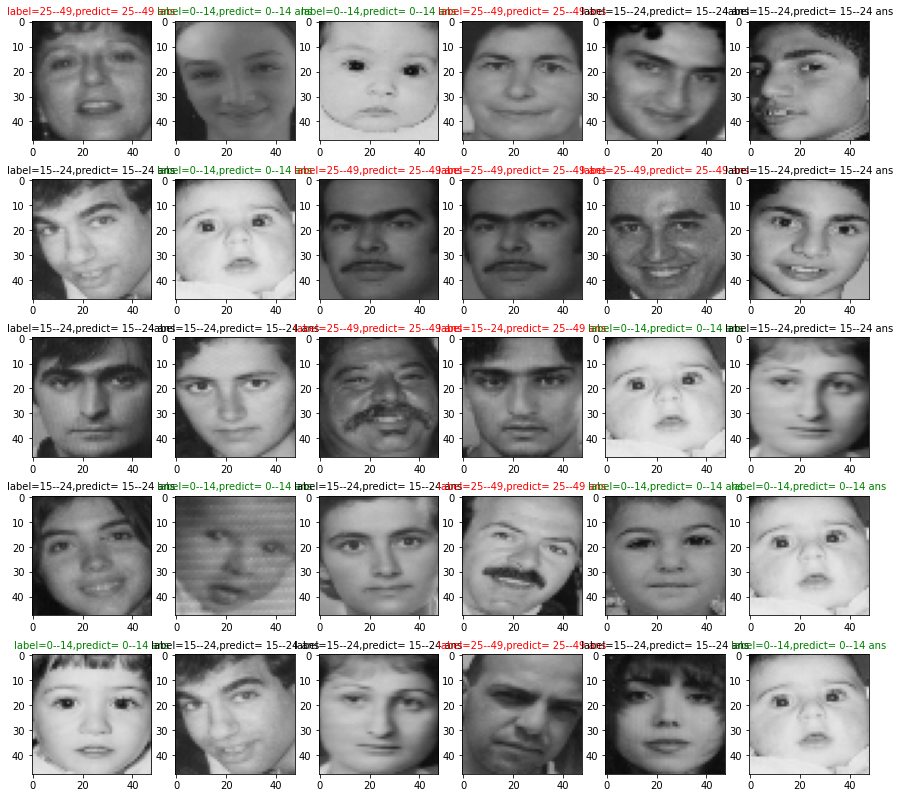

In [ ]:
import matplotlib.pyplot as plt 
import random as rdm 
prediction=(best_model.predict(D_Test))
fig=plt.gcf()
fig.set_size_inches(15, 17)
for i in range(30):
    for j in range (3):
        r=rdm.randint(0,33) 
        ax=plt.subplot(6,6, i+1) 
        ax.imshow(D_Test[r])
        title="label=" + str(labell[r])

        if (np.argmax(prediction[r])==0):
           title += ",predict= 0--14 ans" 
           ax.set_title(title, fontsize=10, color="Green")
        if (np.argmax(prediction[r])==1):
           title += ",predict= 15--24 ans" 
           ax.set_title(title, fontsize=10, color="Black")
        if (np.argmax(prediction[r])==2):
           title += ",predict= 25--49 ans" 
           ax.set_title(title, fontsize=10,color='Red')
        if (np.argmax(prediction[r])==3):
          title += ",predict= 50+ ans" 
          ax.set_title(title, fontsize=10,color='Blue')



 
plt.show()

In [ ]:
#Model Save
best_model.save_weights('model_weightsFG.h5')
best_model.save('model_kerasFG.h5')